<a href="https://colab.research.google.com/github/himanshudas13/Land-Use-Land-Cover/blob/master/Prediction/FruitRipening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MOUUNT DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORT AND INSTALL DEPENDENCIES**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LSTM, TimeDistributed, Dense, Reshape, Input,Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dense, Flatten, Reshape, Input
from tensorflow.keras.models import Model

**CREATE YOUR OWN IMAGE SET**

In [ ]:

# Define the width, height, and the number of images
width, height = 200, 200
num_images = 40
step = width // num_images

# Define the folder path
folder_path = "/content/Rectangles"

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Loop through and create each image
for i in range(num_images):
    # Create a new white image
    img = Image.new('RGB', (width, height), color='red')
    draw = ImageDraw.Draw(img)

    # Draw a black rectangle with increasing size
    draw.rectangle([0, 0, step * (i + 1), height], fill='black')

    # Save the image in the specified folder
    img.save(f"{folder_path}/image_{i + 1:02d}.png")


**TRANSFORM AND DISPLAY IMAGES**

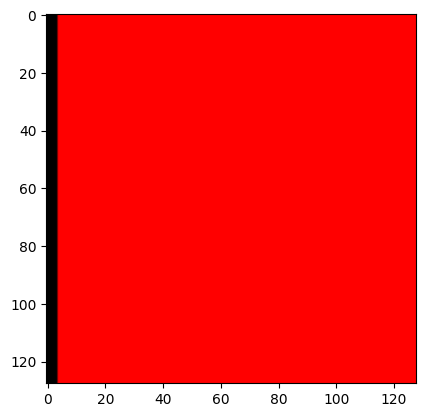

0.0 n 1.0


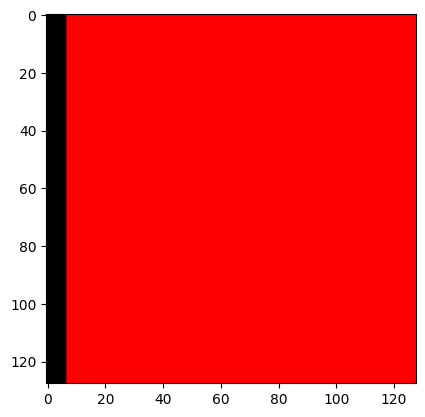

0.0 n 1.0


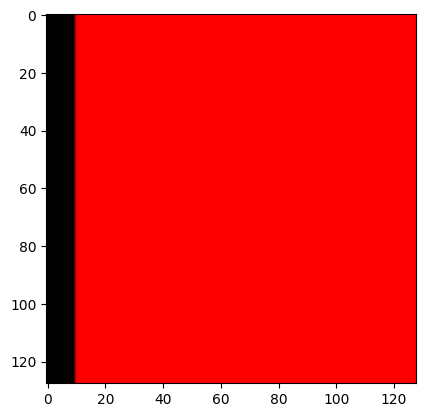

0.0 n 1.0


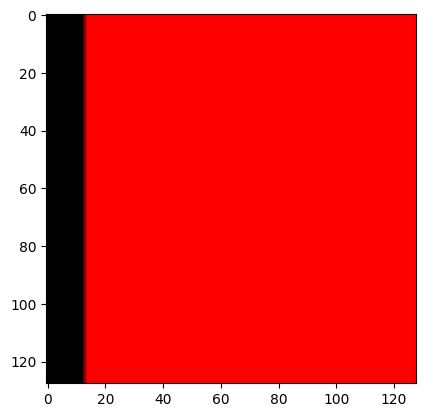

0.0 n 1.0


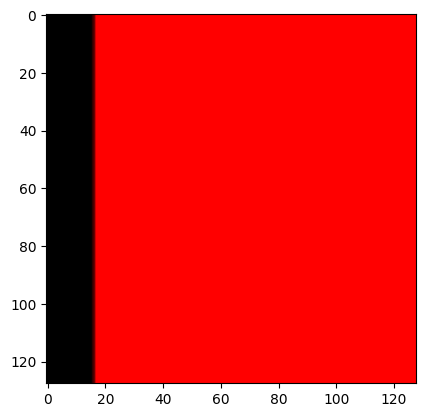

0.0 n 1.0


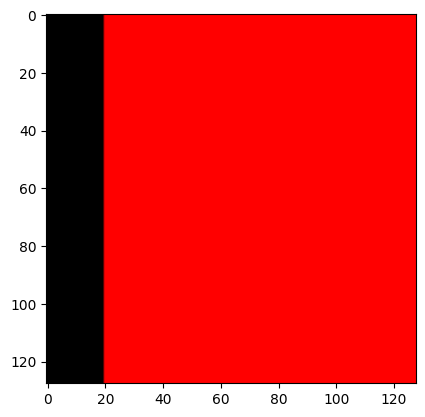

0.0 n 1.0


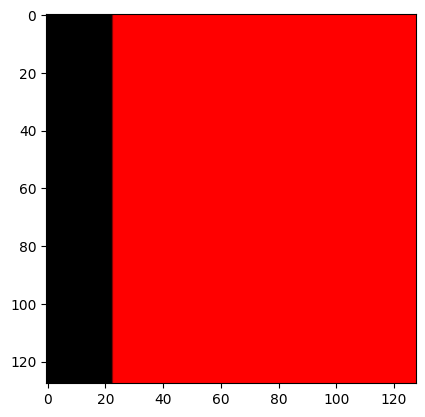

0.0 n 1.0


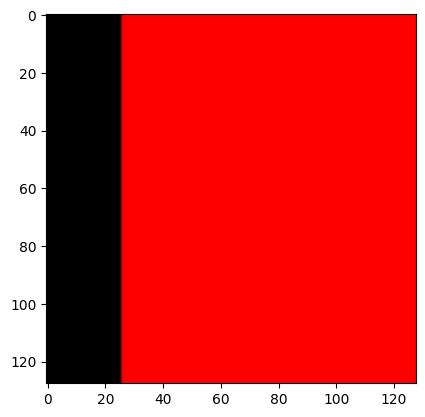

0.0 n 1.0


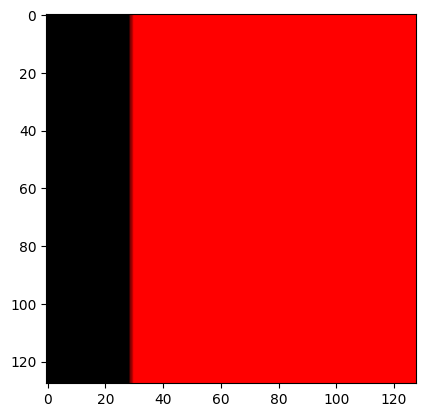

0.0 n 1.0


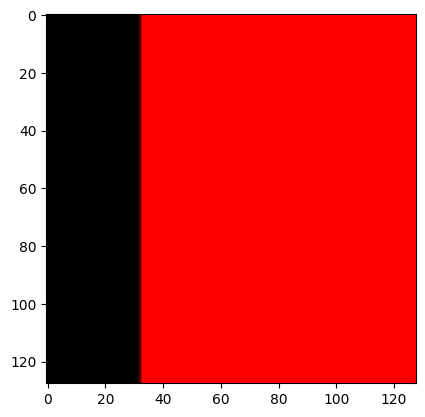

0.0 n 1.0


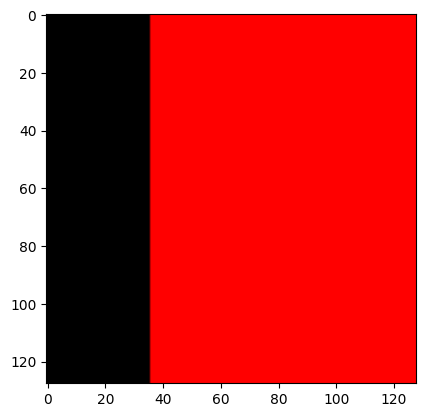

0.0 n 1.0


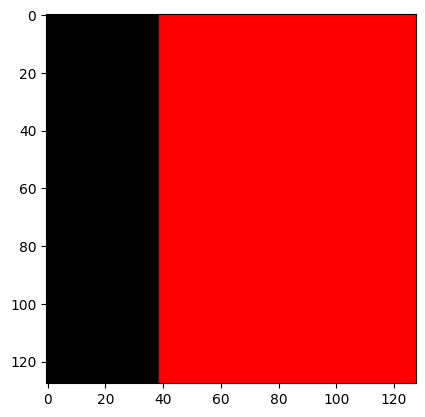

In [ ]:
input_shape = (128, 128, 3)  # Desired shape of input images
time_steps = 2  # Number of time steps in the series
data_dir = '/content/Rectangles'

def load_and_preprocess_images(data_dir, input_shape):
    images = []
    for filename in sorted(os.listdir(data_dir)):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(data_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (input_shape[0], input_shape[1]))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for Matplotlib
            plt.show()
            img = img / 255.0  # Normalize to [0, 1]
            print(f'{img.min()} n {img.max()}')

            images.append(img)
    return np.array(images)

# Load images
images = load_and_preprocess_images(data_dir, input_shape)




**MODEL BUILDING**


In [ ]:
split_index = int(30)
image_train=images[:split_index]
image_test=images[split_index:]
print(image_train.shape)
print(image_test.shape)


(30, 128, 128, 3)
(10, 128, 128, 3)


In [ ]:
def prepare_data_for_lstm( encoded_features, time_steps):

    # Prepare time series data
    X, y = [], []
    for i in range(len(encoded_features) - time_steps):
        # Input sequence (time_steps images)
        X.append(encoded_features[i:i + time_steps])

        # Output (next feature vector or target)
        y.append(encoded_features[i + time_steps])

    return np.array(X), np.array(y)


In [ ]:
X_train, y_train = prepare_data_for_lstm(image_train, time_steps)
print(X_train.shape)
print(y_train.shape)

(28, 2, 128, 128, 3)
(28, 128, 128, 3)


In [ ]:
X_test, y_test = prepare_data_for_lstm(image_test, time_steps)
print(X_test.shape)
print(y_test.shape)

(8, 2, 128, 128, 3)
(8, 128, 128, 3)


In [ ]:

def create_cnn_encoder(input_shape):
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=input_shape))

    # Apply Conv2D and MaxPooling2D inside TimeDistributed
    model.add(layers.TimeDistributed(layers.Conv2D(8, (3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))

    # model.add(layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding='same')))
    # model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))

    model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))

    # Flatten the features
    model.add(layers.TimeDistributed(layers.Flatten()))

    # Reduce dimensions to 16
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))

    return model



In [ ]:
# Example usage:
input_shape = (2, 128, 128, 3)  # Sequence length of 2, image size 128x128, 3 channels
cnn_encoder = create_cnn_encoder(input_shape)
cnn_encoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 2, 128, 128, 8)      │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 2, 64, 64, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 2, 64, 64, 32)       │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 2, 32, 32, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 2, 32768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 2, 32)               │       1,048,608 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,051,168 (4.01 MB)

 Trainable params: 1,051,168 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
img_encoded=cnn_encoder.predict(X_train)
print(img_encoded.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
(28, 2, 32)


In [ ]:

# def create_lstm_model(encoded_feature_shape, time_steps):
#     model = models.Sequential()

#     # Input Layer
#     model.add(layers.Input(shape=(time_steps, *encoded_feature_shape)))

#     # LSTM layer 1 with reduced units
#     model.add(layers.LSTM(32, return_sequences=True, activation='relu'))

#     # LSTM layer 2 with reduced units
#     model.add(layers.LSTM(16, return_sequences=True, activation='relu'))

#     # LSTM layer 3 to output a feature vector for the decoder
#     model.add(layers.LSTM(32, return_sequences=False, activation='relu'))

#     return model


In [ ]:
def create_lstm_model(encoded_feature_shape, time_steps):
    model = models.Sequential()

    # Input Layer
    model.add(layers.Input(shape=(time_steps, *encoded_feature_shape)))

    # RNN layer 1 with reduced units
    model.add(layers.SimpleRNN(16, return_sequences=True, activation='relu'))

    # RNN layer 2 with reduced units
    model.add(layers.SimpleRNN(8, return_sequences=True, activation='relu'))

    # RNN layer 3 with 16 units to output a feature vector
    model.add(layers.SimpleRNN(32, return_sequences=False, activation='relu'))

    return model

In [ ]:
lstm_model = create_lstm_model(img_encoded.shape[2:], time_steps)
lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 2, 16)               │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 2, 8)                │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 32)                  │           1,312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,296 (8.97 KB)

 Trainable params: 2,296 (8.97 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decoder_input=lstm_model.predict(img_encoded)
print(decoder_input.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
(28, 32)


In [ ]:


def create_decoder_model(lstm_output_shape, output_shape):
    model = models.Sequential()

    # Input Layer
    model.add(layers.InputLayer(input_shape=(lstm_output_shape,)))

    # Dense Layer to expand back to a higher-dimensional feature map
    model.add(layers.Dense(16 * 16 * 64, activation='relu'))  # Adjust size to match the intermediate feature map size
    model.add(layers.Reshape((16, 16, 64)))

    # Upsampling and Conv Layers to progressively reconstruct the image
    model.add(layers.UpSampling2D((2, 2)))  # 16x16x64 -> 32x32x64
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

    model.add(layers.UpSampling2D((2, 2)))  # 32x32x64 -> 64x64x64
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

    model.add(layers.UpSampling2D((2, 2)))  # 64x64x32 -> 128x128x32
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))

    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Final layer to output 128x128x3

    return model



In [ ]:


decoder_model = create_decoder_model(decoder_input.shape[1], (128, 128, 3))
decoder_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 16384)               │         540,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 3)         │             435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 601,123 (2.29 MB)

 Trainable params: 601,123 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
predicted_image=decoder_model.predict(decoder_input)
print(predicted_image.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(28, 128, 128, 3)


In [ ]:

# Create the full model
def create_full_model(cnn_encoder, lstm_model, decoder_model, time_steps):

    cnn_input = layers.Input(shape=input_shape)

    cnn_output = cnn_encoder(cnn_input)



    # cnn_output_reshaped = layers.Reshape((time_steps, *cnn_encoder.output_shape[1:]))(cnn_output)
    # # task 3: no need to reshape u can directly take cnn_encoder_output


    # Pass through LSTM
    lstm_output = lstm_model(cnn_output)

    # Pass through Decoder
    decoded_image = decoder_model(lstm_output)

    # Define the full model
    full_model = models.Model(inputs=cnn_input, outputs=decoded_image)

    return full_model

full_model = create_full_model(cnn_encoder, lstm_model, decoder_model, time_steps)

from tensorflow.keras.optimizers import Adam

learning_rate = 0.001  # Adjust this value based on your needs

# Create the Adam optimizer with the custom learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile and train the full model
full_model.compile(optimizer=optimizer, loss='mean_squared_error')
full_model.fit(X_train,y_train,epochs=120, batch_size=X_train.shape[0], validation_split=0.4)




Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.2497 - val_loss: 0.2484
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2485 - val_loss: 0.2452
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2450 - val_loss: 0.2327
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2285 - val_loss: 0.1900
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1730 - val_loss: 0.1076
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1061 - val_loss: 0.0948
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0578 - val_loss: 0.1785
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0829 - val_loss: 0.2010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0875 - val_loss: 0.2038
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0881 - val_loss: 0.2043
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0883 - val_loss: 0.2044
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0882 - val_loss: 0.2040
Epoch 13/10

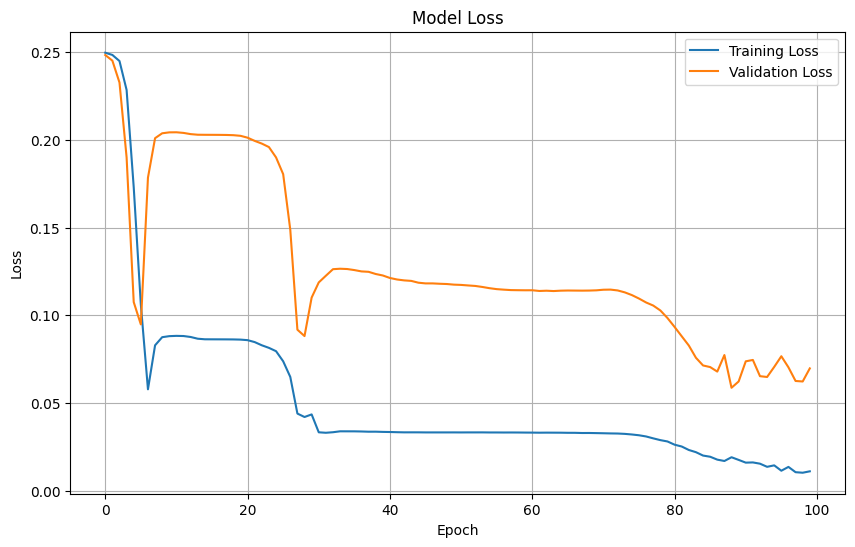

In [ ]:
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import load_model

# Assuming 'full_model' is your trained model and 'history' is the training history object
# Save the model
full_model.save('full_model.h5')

# Save the training history
with open('history.pkl', 'wb') as f:
    pickle.dump(full_model.history.history, f)

# Load the history (for plotting later if needed)
with open('history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model = load_model('/content/full_model.h5')
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 2, 128, 128, 3)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 2, 32)               │       1,051,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 32)                  │           2,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 128, 128, 3)         │         601,123 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,654,589 (6.31 MB)

 Trainable params: 1,654,587 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

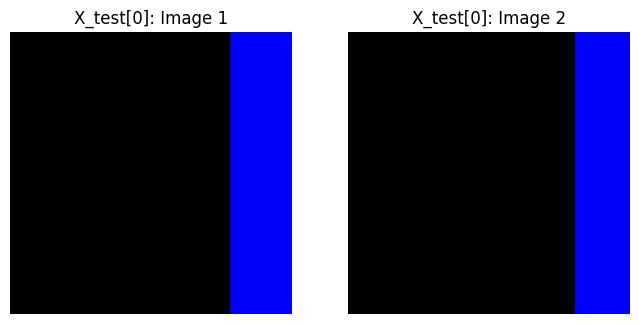

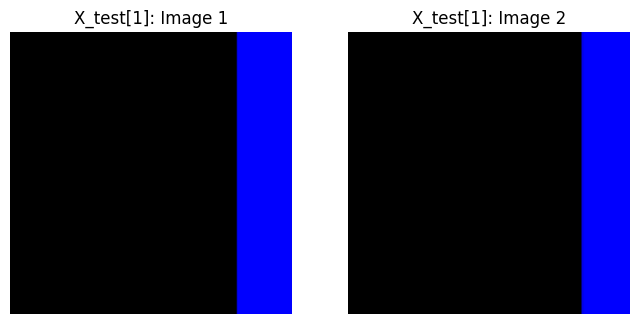

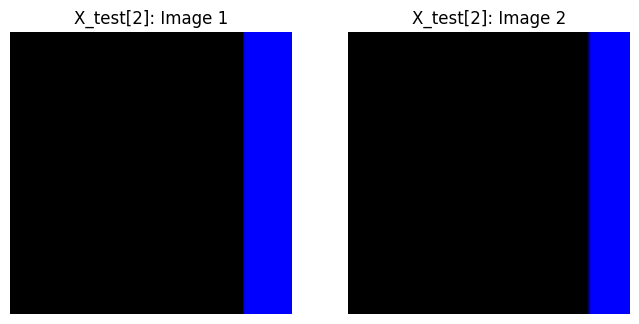

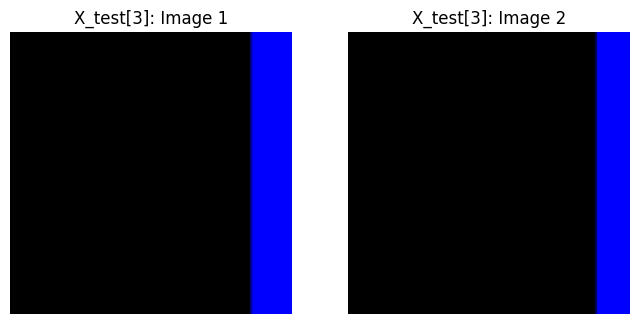

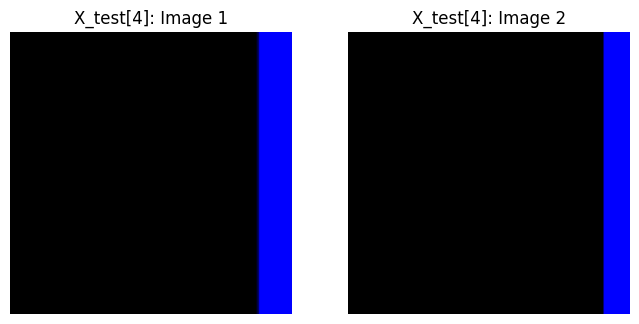

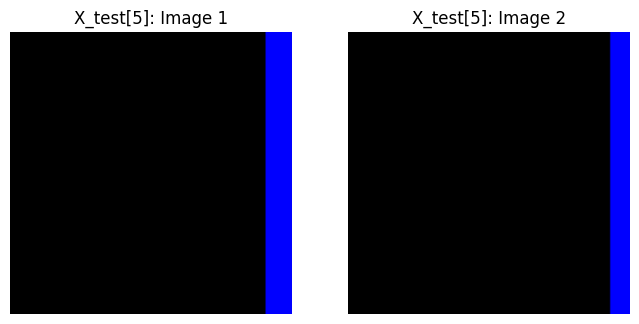

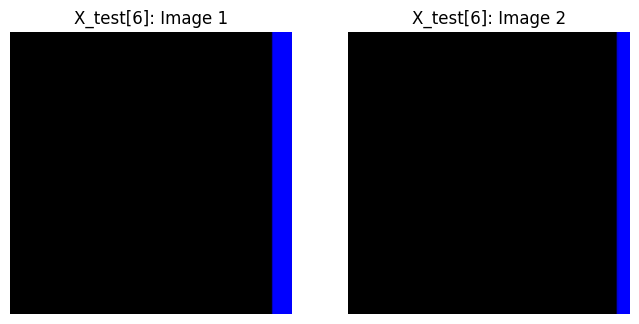

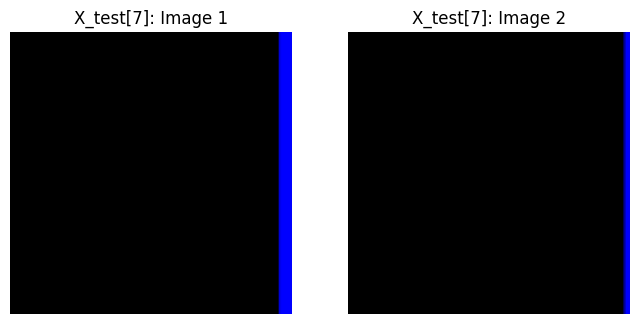

In [ ]:
# import matplotlib.pyplot as plt

# def display_images(X_test):
#     for i, image_pair in enumerate(X_test):
#         plt.figure(figsize=(8, 4))

#         # Display the first image in the pair
#         plt.subplot(1, 2, 1)
#         plt.imshow(image_pair[0])
#         plt.title(f'X_test[{i}]: Image 1')
#         plt.axis('off')

#         # Display the second image in the pair
#         plt.subplot(1, 2, 2)
#         plt.imshow(image_pair[1])
#         plt.title(f'X_test[{i}]: Image 2')
#         plt.axis('off')

#         plt.show()

# # Call the function to display all images in X_test
# display_images(X_test)


to see that it overfits...somewhat works for trained data


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


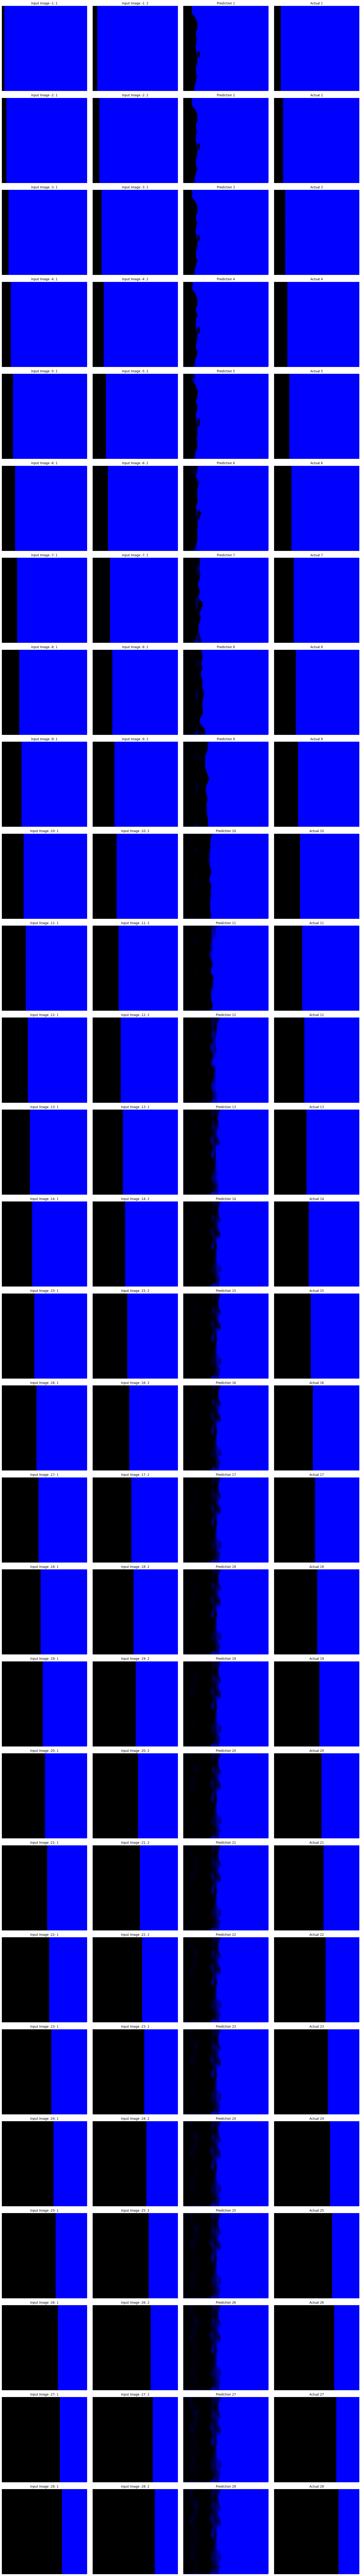

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Make predictions
# predictions = model.predict(X_train)

# # Ensure predictions and y_test have the same length
# assert len(predictions) == len(y_train), "Predictions and y_test length mismatch"

# # Number of pairs (test cases) to plot
# num_pairs = len(predictions)
# height=128
# width=128
# channels=3

# # Plot X_test, predictions, and actual values
# fig, axes = plt.subplots(num_pairs, 4, figsize=(20, 5 * num_pairs))

# for i in range(num_pairs):
#     # Plot first image of the pair from X_test
#     axes[i, 0].imshow(X_train[i][0].reshape((height, width, channels)))
#     axes[i, 0].set_title(f'Input Image -{i+1}: 1')
#     axes[i, 0].axis('off')

#     # Plot second image of the pair from X_test
#     axes[i, 1].imshow(X_train[i][1].reshape((height, width, channels)))
#     axes[i, 1].set_title(f'Input Image -{i+1}: 2')
#     axes[i, 1].axis('off')

#     # Plot prediction
#     axes[i, 2].imshow(predictions[i].reshape((height, width, channels)))
#     axes[i, 2].set_title(f'Prediction {i+1}')
#     axes[i, 2].axis('off')

#     # Plot actual value
#     axes[i, 3].imshow(y_train[i].reshape((height, width, channels)))
#     axes[i, 3].set_title(f'Actual {i+1}')
#     axes[i, 3].axis('off')

# plt.tight_layout()
# plt.show()


performs poorly on test-data



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


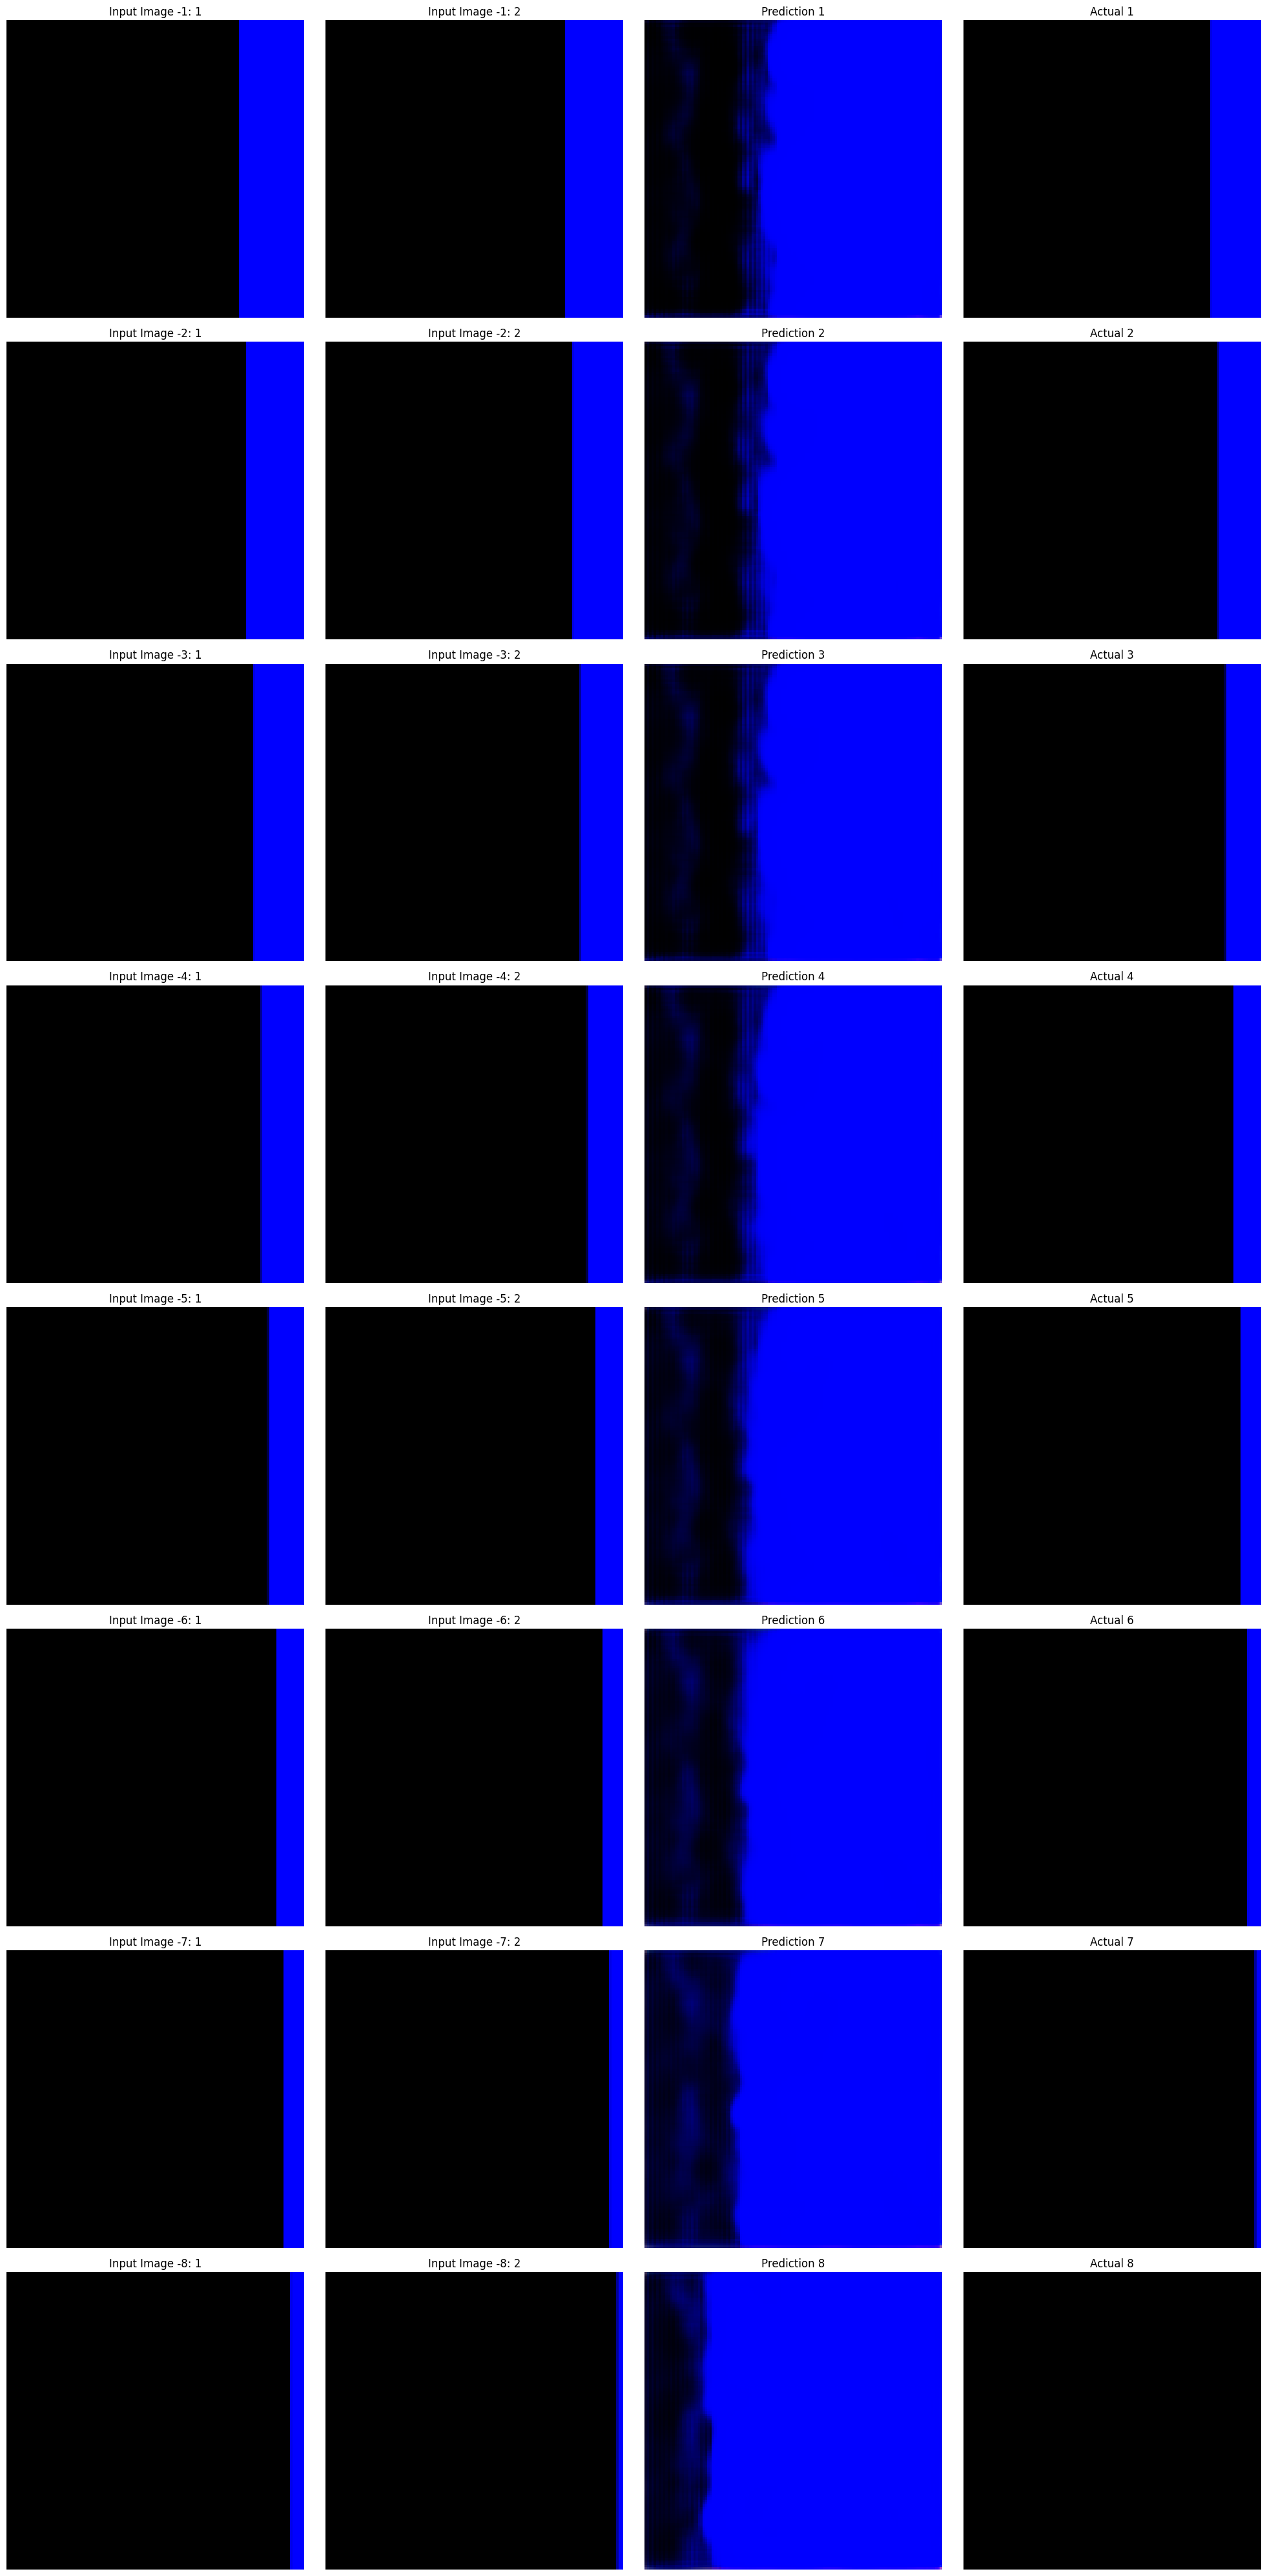

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions
predictions = model.predict(X_test)

# Ensure predictions and y_test have the same length
assert len(predictions) == len(y_test), "Predictions and y_test length mismatch"

# Number of pairs (test cases) to plot
num_pairs = len(predictions)
height=128
width=128
channels=3

# Plot X_test, predictions, and actual values
fig, axes = plt.subplots(num_pairs, 4, figsize=(20, 5 * num_pairs))

for i in range(num_pairs):
    # Plot first image of the pair from X_test
    axes[i, 0].imshow(X_test[i][0].reshape((height, width, channels)))
    axes[i, 0].set_title(f'Input Image -{i+1}: 1')
    axes[i, 0].axis('off')

    # Plot second image of the pair from X_test
    axes[i, 1].imshow(X_test[i][1].reshape((height, width, channels)))
    axes[i, 1].set_title(f'Input Image -{i+1}: 2')
    axes[i, 1].axis('off')

    # Plot prediction
    axes[i, 2].imshow(predictions[i].reshape((height, width, channels)))
    axes[i, 2].set_title(f'Prediction {i+1}')
    axes[i, 2].axis('off')

    # Plot actual value
    axes[i, 3].imshow(y_test[i].reshape((height, width, channels)))
    axes[i, 3].set_title(f'Actual {i+1}')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()
